In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)


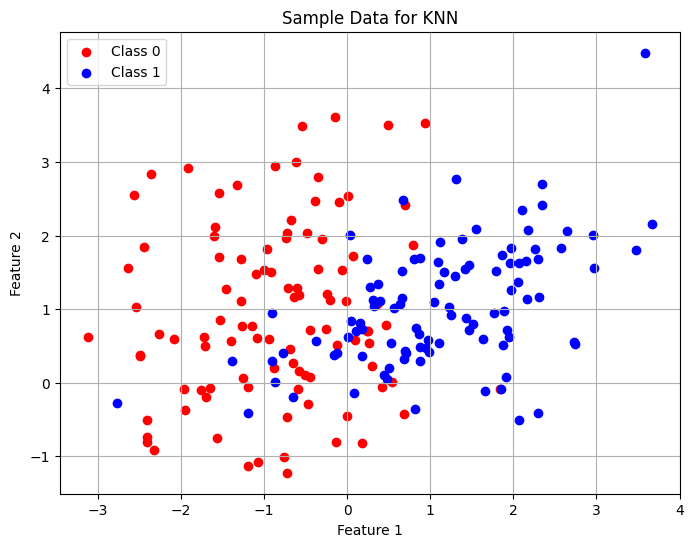

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Sample Data for KNN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

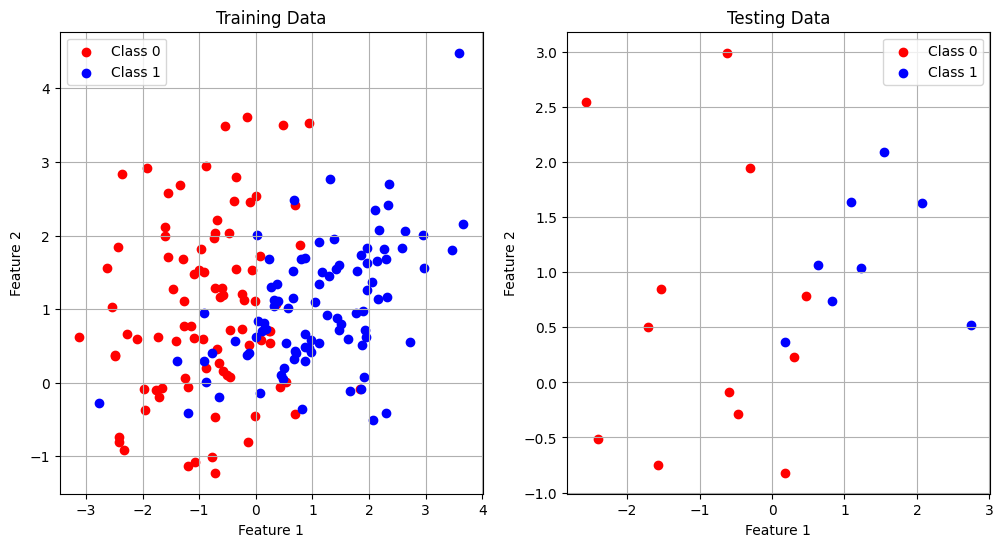

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0')
ax[0].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1')
ax[0].set_title('Training Data')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[0].legend()
ax[0].grid(True)

ax[1].scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='red', label='Class 0')
ax[1].scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='blue', label='Class 1')
ax[1].set_title('Testing Data')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
ax[1].legend()
ax[1].grid(True)

plt.show()

In [6]:
import ipywidgets as widgets
from ipywidgets import interact

def calculate_distances(X_train, test_point, distance_t='euclidean', p=2):
    """
    Calculate the distance between a test point and each point in the training set.

    Parameters:
    - X_train: Training data points.
    - test_point: The test data point.
    - distance_t: The type of distance metric ('euclidean', 'manhattan', 'minkowski').
    - p: The Minkowski distance order.

    Returns:
    - A numpy array of distances from the test point to each training point.
    """
    if distance_t == 'euclidean':
        distances = np.sqrt(np.sum((X_train - test_point) ** 2, axis=1))
    elif distance_t == 'manhattan':
        distances = np.sum(np.abs(X_train - test_point), axis=1)
    elif distance_t == 'minkowski':
        distances = np.sum(np.abs(X_train - test_point) ** p, axis=1) ** (1 / p)
    else:
        raise ValueError(f"Unknown distance metric: {distance_t}")
    return distances

@interact(
    k=widgets.IntSlider(min=1, max=X_train.shape[0], step=1, value=3),
    distance_t=widgets.Dropdown(options=['euclidean', 'manhattan', 'minkowski'], value='euclidean', description='Distance Type'),
    lines=widgets.Checkbox(value=True, description='Show Lines'),
    calculated_radius=widgets.Checkbox(value=True, description='Calculate Radius'),
    p=widgets.FloatSlider(min=1, max=10, step=0.1, value=2)
)
def plot_k_close(k, distance_t, lines, calculated_radius, p):
    """
    Plot the k closest points to a test point using KNN.

    Parameters:
    - k: Number of nearest neighbors to consider.
    - distance_t: The distance metric to use.
    - lines: Whether to show lines connecting the test point and neighbors.
    - calculated_radius: Whether to display the calculated radius around the test point.
    - p: The order of the Minkowski distance.
    """
    # Calculate distances from the test point to all training points
    distances = calculate_distances(X_train, X_test[0], distance_t, p)
    
    # Get indices of the k closest points
    k_closest = np.argsort(distances)[:k]
    
    # Set plot context and size
    sns.set_context('talk')
    plt.figure(figsize=(10, 8))
    
    # Plot the test point, training points, and k closest points
    plt.scatter(X_test[0][0], X_test[0][1], color='green', label='Test Point', s=100, edgecolor='black')
    plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0', alpha=0.6)
    plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1', alpha=0.6)
    plt.scatter(X_train[k_closest][:, 0], X_train[k_closest][:, 1], color='orange', label=f'{k} Closest Points', edgecolor='black')
    
    # Calculate the radius as the distance to the furthest of the k closest points
    furthest_neighbor_distance = distances[k_closest[-1]]
    real_radious = np.sort(np.sqrt(np.sum((X_train[k_closest] - X_test[0] ) ** 2, axis=1)))[-1]
    
    # Draw a circle with radius equal to the distance to the furthest k neighbor
    circle = plt.Circle((X_test[0][0], X_test[0][1]), real_radious, color='red', fill=True, alpha=0.1, label='K-Distance')
    plt.gca().add_artist(circle)

    # Optionally show the calculated radius
    if calculated_radius:
        calculated_circle = plt.Circle((X_test[0][0], X_test[0][1]), furthest_neighbor_distance, color='orange', fill=True, alpha=0.2, label='Calculated Radius')
        plt.gca().add_artist(calculated_circle)
    
    # Add lines from the test point to the k closest points
    if lines:
        for i in k_closest:
            plt.plot([X_test[0][0], X_train[i][0]], [X_test[0][1], X_train[i][1]], 'k--', alpha=0.3)

    # Plot formatting and labels
    plt.title('K-Nearest Neighbors Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis('equal')  # Ensures equal aspect ratio
    plt.legend()
    plt.grid(True)
    plt.show()

interactive(children=(IntSlider(value=3, description='k', max=180, min=1), Dropdown(description='Distance Type…

In [7]:
def majority_vote(labels):
    """
    Return the most common element in an array of labels.

    Parameters:
    - labels: An array of labels.

    Returns:
    - The most common element in the array.
    """
    return np.bincount(labels).argmax()

@interact(
    k=widgets.IntSlider(min=1, max=X_train.shape[0], step=1, value=3),
    mode=widgets.ToggleButtons(options=['Classification', 'Regression'], value='Classification', description='Mode'),
    distance_t=widgets.Dropdown(options=['euclidean', 'manhattan', 'minkowski'], value='euclidean', description='Distance Type'),
    lines=widgets.Checkbox(value=True, description='Show Lines'),
    calculated_radius=widgets.Checkbox(value=True, description='Calculate Radius'),
    p=widgets.FloatSlider(min=1, max=10, step=0.1, value=2)
)
def plot_k_close(k, mode, distance_t, lines, calculated_radius, p):
    """
    Plot the k closest points to a test point using KNN.

    Parameters:
    - k: Number of nearest neighbors to consider.
    - mode: 'Classification' or 'Regression'.
    - distance_t: The distance metric to use.
    - lines: Whether to show lines connecting the test point and neighbors.
    - calculated_radius: Whether to display the calculated radius around the test point.
    - p: The order of the Minkowski distance.
    """
    # Calculate distances from the test point to all training points
    distances = calculate_distances(X_train, X_test[0], distance_t, p)
    
    # Get indices of the k closest points
    k_closest = np.argsort(distances)[:k]
    
    # Set plot context and size
    sns.set_context('talk')
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))  # Corrected subplot creation
    
    # Plot the test point, training points, and k closest points
    ax[0].scatter(X_test[0][0], X_test[0][1], color='green', label='Test Point', s=100, edgecolor='black')
    ax[0].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0', alpha=0.6)
    ax[0].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1', alpha=0.6)
    ax[0].scatter(X_train[k_closest][:, 0], X_train[k_closest][:, 1], color='orange', label=f'{k} Closest Points', edgecolor='black')
    
    ax[2].scatter(X_test[0][0], X_test[0][1], color='green', label='Test Point', s=100, edgecolor='black')
    ax[2].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0', alpha=0.6)
    ax[2].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1', alpha=0.6)

    # Calculate the radius as the distance to the furthest of the k closest points
    furthest_neighbor_distance = distances[k_closest[-1]]
    real_radious = np.sort(np.sqrt(np.sum((X_train[k_closest] - X_test[0]) ** 2, axis=1)))[-1]
    
    # Draw a circle with radius equal to the distance to the furthest k neighbor
    circle1 = plt.Circle((X_test[0][0], X_test[0][1]), real_radious, color='red', fill=True, alpha=0.1, label='K-Distance')
    ax[0].add_artist(circle1)

    circle2 = plt.Circle((X_test[0][0], X_test[0][1]), real_radious, color='red', fill=True, alpha=0.1, label='K-Distance')
    ax[2].add_artist(circle2)

    # Optionally show the calculated radius
    if calculated_radius:
        calculated_circle1 = plt.Circle((X_test[0][0], X_test[0][1]), furthest_neighbor_distance, color='orange', fill=True, alpha=0.2, label='Calculated Radius')
        ax[0].add_artist(calculated_circle1)

        calculated_circle2 = plt.Circle((X_test[0][0], X_test[0][1]), furthest_neighbor_distance, color='orange', fill=True, alpha=0.2, label='Calculated Radius')
        ax[2].add_artist(calculated_circle2)
    
    # Add lines from the test point to the k closest points
    if lines:
        for i in k_closest:
            ax[0].plot([X_test[0][0], X_train[i][0]], [X_test[0][1], X_train[i][1]], 'k--', alpha=0.3)

    if mode == 'Classification':
        # Get the majority vote of the k closest points
        majority = majority_vote(y_train[k_closest])

        # Count the occurrences of each class
        unique, counts = np.unique(y_train[k_closest], return_counts=True)
        class_counts = dict(zip(unique, counts))

        # Make the plot filled with color in ax[1] based on majority vote
        if majority == 0:
            ax[1].set_facecolor('red')
        else:
            ax[1].set_facecolor('blue')

        # Add text annotations for class counts
        ax[1].text(0.5, 0.5, f'Class 0: {class_counts.get(0, 0)}\nClass 1: {class_counts.get(1, 0)}',
                   horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
                   fontsize=14, color='white', bbox=dict(facecolor='black', alpha=0.6, boxstyle='round'))

        ax[1].set_title('Prediction Visualization')

    elif mode == 'Regression':
        # Calculate the mean of the k closest points' labels for regression
        regression_value = np.mean(y_train[k_closest])

        # Plot regression value as a color intensity (e.g., grayscale)
        color_intensity = (regression_value - y_train.min()) / (y_train.max() - y_train.min())
        ax[1].set_facecolor((color_intensity, color_intensity, color_intensity))

        # Add text annotation for regression value
        ax[1].text(0.5, 0.5, f'Regression Value:\n{regression_value:.2f}',
                   horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
                   fontsize=14, color='white', bbox=dict(facecolor='black', alpha=0.6, boxstyle='round'))

        ax[1].set_title('Regression Value Visualization')

    # Plot formatting and labels
    ax[0].set_title('K-Nearest Neighbors Visualization')
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')
    ax[0].axis('equal')
    ax[0].legend()
    ax[0].grid(True)

    ax[2].set_title('K-Nearest Neighbors Visualization')

interactive(children=(IntSlider(value=3, description='k', max=180, min=1), ToggleButtons(description='Mode', o…

In [8]:
def knn_predict(X_train, y_train, test_point, k, mode='Classification', distance_t='euclidean', p=2):
    """
    Predict the output for a given test point using KNN.
    
    Parameters:
    - X_train: Training data points.
    - y_train: Training labels.
    - test_point: The point for which prediction is made.
    - k: Number of nearest neighbors to consider.
    - mode: 'Classification' or 'Regression'.
    - distance_t: The distance metric to use.
    - p: The order of the Minkowski distance.
    
    Returns:
    - The predicted class or regression value.
    """
    # Calculate distances from the test point to all training points
    distances = calculate_distances(X_train, test_point, distance_t, p)
    
    # Get indices of the k closest points
    k_closest = np.argsort(distances)[:k]
    
    if mode == 'Classification':
        # Get the majority vote of the k closest points
        return majority_vote(y_train[k_closest])
    elif mode == 'Regression':
        # Calculate the mean of the k closest points' labels for regression
        return np.mean(y_train[k_closest])
    else:
        raise ValueError("Invalid mode.")

@interact(
    k=widgets.IntSlider(min=1, max=X_train.shape[0], step=1, value=3),
    mode=widgets.ToggleButtons(options=['Classification', 'Regression'], value='Classification', description='Mode'),
    distance_t=widgets.Dropdown(options=['euclidean', 'manhattan', 'minkowski'], value='euclidean', description='Distance Type'),
    lines=widgets.Checkbox(value=True, description='Show Lines'),
    calculated_radius=widgets.Checkbox(value=True, description='Calculate Radius'),
    p=widgets.FloatSlider(min=1, max=10, step=0.1, value=2)
)
def plot_k_close(k, mode, distance_t, lines, calculated_radius, p):
    """
    Plot the k closest points to a test point using KNN.

    Parameters:
    - k: Number of nearest neighbors to consider.
    - mode: 'Classification' or 'Regression'.
    - distance_t: The distance metric to use.
    - lines: Whether to show lines connecting the test point and neighbors.
    - calculated_radius: Whether to display the calculated radius around the test point.
    - p: The order of the Minkowski distance.
    """
    # Calculate distances from the test point to all training points
    distances = calculate_distances(X_train, X_test[0], distance_t, p)
    
    # Get indices of the k closest points
    k_closest = np.argsort(distances)[:k]
    
    # Set plot context and size
    sns.set_context('talk')
    fig, ax = plt.subplots(1, 4, figsize=(32, 8))  # Added subplot for meshgrid visualization
    
    # Plot the test point, training points, and k closest points
    ax[0].scatter(X_test[0][0], X_test[0][1], color='green', label='Test Point', s=100, edgecolor='black')
    ax[0].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0', alpha=0.6)
    ax[0].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1', alpha=0.6)
    ax[0].scatter(X_train[k_closest][:, 0], X_train[k_closest][:, 1], color='orange', label=f'{k} Closest Points', edgecolor='black')
    
    ax[2].scatter(X_test[0][0], X_test[0][1], color='green', label='Test Point', s=100, edgecolor='black')
    ax[2].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0', alpha=0.6)
    ax[2].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1', alpha=0.6)

    # Calculate the radius as the distance to the furthest of the k closest points
    furthest_neighbor_distance = distances[k_closest[-1]]
    real_radious = np.sort(np.sqrt(np.sum((X_train[k_closest] - X_test[0]) ** 2, axis=1)))[-1]
    
    # Draw a circle with radius equal to the distance to the furthest k neighbor
    circle1 = plt.Circle((X_test[0][0], X_test[0][1]), real_radious, color='red', fill=True, alpha=0.1, label='K-Distance')
    ax[0].add_artist(circle1)

    circle2 = plt.Circle((X_test[0][0], X_test[0][1]), real_radious, color='red', fill=True, alpha=0.1, label='K-Distance')
    ax[2].add_artist(circle2)

    # Optionally show the calculated radius
    if calculated_radius:
        calculated_circle1 = plt.Circle((X_test[0][0], X_test[0][1]), furthest_neighbor_distance, color='orange', fill=True, alpha=0.2, label='Calculated Radius')
        ax[0].add_artist(calculated_circle1)

        calculated_circle2 = plt.Circle((X_test[0][0], X_test[0][1]), furthest_neighbor_distance, color='orange', fill=True, alpha=0.2, label='Calculated Radius')
        ax[2].add_artist(calculated_circle2)
    
    # Add lines from the test point to the k closest points
    if lines:
        for i in k_closest:
            ax[0].plot([X_test[0][0], X_train[i][0]], [X_test[0][1], X_train[i][1]], 'k--', alpha=0.3)

    if mode == 'Classification':
        # Get the majority vote of the k closest points
        majority = majority_vote(y_train[k_closest])

        # Count the occurrences of each class
        unique, counts = np.unique(y_train[k_closest], return_counts=True)
        class_counts = dict(zip(unique, counts))

        # Make the plot filled with color in ax[1] based on majority vote
        if majority == 0:
            ax[1].set_facecolor('red')
        else:
            ax[1].set_facecolor('blue')

        # Add text annotations for class counts
        ax[1].text(0.5, 0.5, f'Class 0: {class_counts.get(0, 0)}\nClass 1: {class_counts.get(1, 0)}',
                   horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
fontsize=14, color='white', bbox=dict(facecolor='black', alpha=0.6, boxstyle='round'))
        ax[1].set_title('Majority Vote Visualization')

    elif mode == 'Regression':
        # Calculate the mean of the k closest points' labels for regression
        regression_value = np.mean(y_train[k_closest])

        # Plot regression value as a color intensity (e.g., grayscale)
        color_intensity = (regression_value - y_train.min()) / (y_train.max() - y_train.min())
        ax[1].set_facecolor((color_intensity, color_intensity, color_intensity))

        # Add text annotation for regression value
        ax[1].text(0.5, 0.5, f'Regression Value:\n{regression_value:.2f}',
                horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
                fontsize=14, color='white', bbox=dict(facecolor='black', alpha=0.6, boxstyle='round'))

        ax[1].set_title('Regression Value Visualization')

    # Generate meshgrid for decision boundary visualization
    x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Predict over the meshgrid
    if mode == 'Classification':
        zz = np.array([knn_predict(X_train, y_train, point, k, mode='Classification', distance_t=distance_t, p=p) for point in grid_points])
        zz = zz.reshape(xx.shape)
        ax[3].contourf(xx, yy, zz, alpha=0.6, cmap=plt.cm.RdBu)
        ax[3].scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0', alpha=0.6)
        ax[3].scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1', alpha=0.6)

    elif mode == 'Regression':
        zz = np.array([knn_predict(X_train, y_train, point, k, mode='Regression', distance_t=distance_t, p=p) for point in grid_points])
        zz = zz.reshape(xx.shape)
        ax[3].contourf(xx, yy, zz, alpha=0.6, cmap=plt.cm.viridis)
        ax[3].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.viridis, edgecolor='k', s=50)

    # Plot formatting and labels
    ax[0].set_title('K-Nearest Neighbors Visualization')
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')
    ax[0].axis('equal')
    ax[0].legend()
    ax[0].grid(True)

    ax[2].set_title('K-Nearest Neighbors Visualization')
    ax[2].set_xlabel('Feature 1')
    ax[2].set_ylabel('Feature 2')
    ax[2].axis('equal')
    ax[2].legend()
    ax[2].grid(True)

    ax[1].set_xlabel('Feature 1')
    ax[1].set_ylabel('Feature 2')
   

    ax[3].set_title('Decision Boundary' if mode == 'Classification' else 'Regression Surface')
    ax[3].set_xlabel('Feature 1')
    ax[3].set_ylabel('Feature 2')
    ax[3].axis('equal')
    ax[3].grid(True)

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=3, description='k', max=180, min=1), ToggleButtons(description='Mode', o…